# Face Detection and Recognition

[Download Trained Model](https://drive.google.com/file/d/154_qjqhBeMeTtErHihMU7TaolFS14_W1/view?usp=sharing)

In [1]:
import torch
from torch import nn, optim
import os
import cv2
import numpy as np
import pickle
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from typing import TYPE_CHECKING
%matplotlib inline

if TYPE_CHECKING:
    from PIL.Image import Image

In [2]:
# Settings
DICTPATH = "face_codes.dict"
MODEL_PATH = "FaceMatcher.pt"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Class and Function Definations

In [3]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive
    
class FaceMatcher(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnns = nn.Sequential(
            nn.Conv2d(1, 4, padding=1, stride=2, kernel_size=3),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(4),
            
            nn.Conv2d(4, 8, padding=1, stride=2, kernel_size=3),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(8),


            nn.Conv2d(8, 16, padding=1, stride=2, kernel_size=3),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(16),
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16*13**2, 500),
            nn.LeakyReLU(0.2),

            nn.Linear(500, 100),
            nn.LeakyReLU(0.2),

            nn.Linear(100, 5)
        )
        
        self.criterion = ContrastiveLoss()
        self.optimizer = optim.Adam(self.parameters(), lr = 0.0005 )
    
    def check_output_sizes(self, input_size: tuple[int, ...]):
        x = torch.zeros(*input_size)
        print("Input ->", input_size, "\n")
        with torch.no_grad():
            self.eval()
            for layer in self.cnns.children():
                x = layer(x)
                print(f"{layer.__class__.__name__} -> {tuple(x.shape)}\n")
                
            for layer in self.fc.children():
                x = layer(x)
                print(f"{layer.__class__.__name__} -> {tuple(x.shape)}\n")
            self.train()
    
    def get_face_code(self, x):
        output = self.cnns(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def forward(self, input1, input2):
        output1 = self.get_face_code(input1)
        output2 = self.get_face_code(input2)
        return output1, output2
    
    def optimize(self, input1, input2, label):
        self.optimizer.zero_grad()
        output1, output2 = self(input1, input2)
        loss = self.criterion(output1, output2, label)
        loss.backward()
        self.optimizer.step()
        return loss        

### Functions

In [4]:
def cv2_to_pil(img: 'ndarray') -> 'Image':
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(img)
    return pil_img

def pil_to_cv2(img: 'Image'):
    img = np.array(img)
    cv2_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return cv2_img

def crop_face(image: 'Image'):
    img = pil_to_cv2(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    detector = cv2.CascadeClassifier("data/haarcascade_frontalface_default.xml")
    result = detector.detectMultiScale(img, scaleFactor=1.05,minNeighbors=5,
                                      minSize=(img.shape[0]//5, img.shape[1]//5))
    
    if len(result)>1:
        print("Warning: More than one face detected, cropped face may not be accurate")
    x, y, w, h = result[0]
    img = img[y:y + h, x:x + w]
        
    img = cv2.resize(img, (100,100), interpolation = cv2.INTER_CUBIC).astype(np.float32)
    return torch.from_numpy(img/255).unsqueeze(0)


def add_person(name: str, image_path: str, model: FaceMatcher, dictpath: str):
    img = crop_face(Image.open(image_path))
    with torch.no_grad():
        fcode = model.get_face_code(img.unsqueeze(0)).squeeze()
        
    if os.path.exists(dictpath):
        with open(dictpath, "rb") as f:
            face_codes = pickle.load(f)
    else:
        face_codes = {}
        
    face_codes[name] = fcode
    with open(dictpath, "wb") as f:
        pickle.dump(face_codes, f)
        print(f"{name} added to dict.")
        
def remove_person(name: str, dictpath: str):
    with open(dictpath, "rb") as f:
        face_codes = pickle.load(f)
        
    del face_codes[name]
    
    with open(dictpath, "wb") as f:
        pickle.dump(face_codes, f)
        print(f"{name} removed from dict.")
        
def match_face(image_path: str, model, dictpath: str):
    img = crop_face(Image.open(image_path))
    with torch.no_grad():
        fcode = model.get_face_code(img.unsqueeze(0)).squeeze()
        
    with open(dictpath, "rb") as f:
        face_codes = pickle.load(f)
        
    best_match = {"name": None, "distance": 9999.}
    for name, face_code in face_codes.items():
        d = F.pairwise_distance(fcode, face_code).item()
        if d<=2 and d < best_match["distance"]:
            best_match = {"name": name, "distance": d}
            
    best_match["image"] = img.squeeze()
    return best_match

def detect_faces(image: 'Image'):
    img = pil_to_cv2(image)
    grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    detector = cv2.CascadeClassifier("data/haarcascade_frontalface_default.xml")
    results = detector.detectMultiScale(grayimg, scaleFactor=1.05, 
                                        minSize=(img.shape[0]//4, img.shape[1]//4), minNeighbors=5)
    
    for x, y, w, h in results:
        cv2.rectangle(img, (x,y), (x+w,y+h), (255,0,0), 2)
        
    return img

### Loading Model

In [5]:
model = FaceMatcher()
model.load_state_dict(torch.load(MODEL_PATH, DEVICE))

<All keys matched successfully>

## Application

### Inputs

Path of image file which contains face to be detected and recognized

In [6]:
IMAGE_PATH = "data/inference/Elon Musk/3.jpg"

### Face Detection

(1054, 1581, 3)


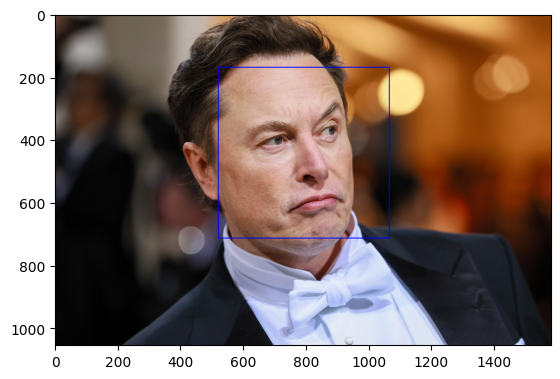

In [7]:
img = Image.open(IMAGE_PATH)
img = detect_faces(img)
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

### Face Recognition

#### Add/Remove reference images from 'face_codes.dict'

Added images will be used to identify the person

In [8]:
add_person(name="Narendra Modi", image_path="data/inference/Narendra Modi/1.jpg", model=model, dictpath=DICTPATH)

Narendra Modi added to dict.


In [9]:
# remove_person("G", DICTPATH)

#### Recognize face

Model will try to recognize face in image located at IMAGE_PATH

Person identified to be Elon Musk.
Dissimilarity Score - 1.7274361848831177


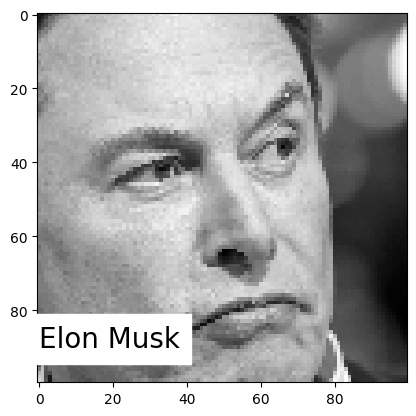

In [10]:
best_match = match_face(IMAGE_PATH, model, DICTPATH)
plt.imshow(best_match["image"], cmap="gray")
if best_match["name"] is not None:
    plt.text(0, 90, best_match["name"], backgroundcolor="white", fontsize="20")
    print(f"Person identified to be {best_match['name']}.")
    print("Dissimilarity Score -", best_match["distance"])
else:
    print("No Match Found")

#### Check Entries in 'face_codes.dict'

In [11]:
with open(DICTPATH, "rb") as f:
    face_codes = pickle.load(f)
    for name in face_codes:
        print(name)

Narendra Modi
Elon Musk
Lionel Messi
